# Litteraturbanken Author 
version 1.12 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      Open question how to see [JSON 23](https://github.com/spraakbanken/littb-frontend/issues/23)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> we should not create everyoine in Wikidata 
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter in Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text 
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
We need CC0 to import data in Wikidata (see [Wikidata:Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing)) e.g. if we should add all books as objects in Wikidata with no text and create links to Litteraturbanken then fields like below need to be [CC-0](https://creativecommons.org/share-your-work/public-domain/cc0/)  
* Författare
* Verk
* Libris-id 
* förlaga	
* eid	
* Införd	
* Länk i klartext	
* Epub	
* Källa

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-10-06 10:48:54.286525


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
365,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1600563813891,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3656 non-null   object        
 1   wd_hos_Litteraturbanken  1418 non-null   object        
 2   authorid_norm            3656 non-null   object        
 3   show                     3656 non-null   bool          
 4   updated                  2989 non-null   datetime64[ns]
 5   imported                 2989 non-null   datetime64[ns]
 6   librisid                 1929 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 175.1+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2288
False    1368
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 1 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2288 non-null   object        
 1   wd_hos_Litteraturbanken  1318 non-null   object        
 2   authorid_norm            2288 non-null   object        
 3   show                     2288 non-null   bool          
 4   updated                  1837 non-null   datetime64[ns]
 5   imported                 1837 non-null   datetime64[ns]
 6   librisid                 1212 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 127.4+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:10]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,WägnerE,Q270468,WagnerE,True,2020-09-22,2010-02-17,0xbdgmxj0thr95n
2,JörlinE,NaN,JorlinE,True,2020-09-21,2020-09-21,NaN
3,FechtPM,NaN,FechtPM,True,2020-09-21,2020-09-21,NaN
4,RichardsonJ,NaN,RichardsonJ,True,2020-09-21,2020-09-21,NaN
5,BrattI,NaN,BrattI,True,2020-09-21,2020-09-21,hftwzbq12j7vcjz
6,FrondinE,NaN,FrondinE,True,2020-09-21,2020-09-21,zw9dkwmh3fc7gdr
7,LaurentiusPetriGothus,NaN,LaurentiusPetriGothus,True,2020-09-21,2020-09-21,64jlpf6q2k76524
8,BerglundD,NaN,BerglundD,True,2020-09-21,2020-09-21,NaN
9,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:20]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4
2,JohanIII,NaN,JohanIII,True,2020-09-21,2020-09-21,ljx016344bl6mdn
3,WestdahlP,NaN,WestdahlP,True,2020-09-21,2020-09-21,NaN
4,WahlenbergG,NaN,WahlenbergG,True,2020-09-21,2020-09-21,dbqspmqx0z27d0d
5,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9
6,HolthusenCJ,NaN,HolthusenCJ,True,2020-09-21,2020-09-21,NaN
7,TollinF,NaN,TollinF,True,2020-09-21,2020-09-21,53hkn33p1btlh7l
8,BäckströmPO,NaN,BackstromPO,True,2020-09-21,2020-09-21,53hlqskp2qx9r38
9,DahlgrenL,NaN,DahlgrenL,True,2020-09-21,2020-09-21,42gjklkn56sfzxw


## Wikidata

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1665 non-null   object
 1   authorid    1665 non-null   object
dtypes: object(2)
memory usage: 26.1+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    0
authorid      0
dtype: int64

## Merge Litteraturbanken dataset with Wikidata

In [16]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge[0:10]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,2018-10-25,2018-10-25,NaN,both
3,Q365923,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both
5,Q109244,AdamBremen,Q109244,AdamBremen,True,2019-10-16,2014-02-05,53hkk5vp1k798w1,both
6,Q4933819,AdelborgO,Q4933819,AdelborgO,True,2019-10-16,2008-11-11,sq466t3b4s743md,both
7,Q3338577,AdlerbethGJ,Q3338577,AdlerbethGJ,True,2019-10-16,2010-10-19,wt794lsf0mx0xqp,both
8,Q918652,AdlersparreG,Q918652,AdlersparreG,True,2019-10-16,2015-02-16,86lnqg0s0b2bxhx,both
9,Q4346827,AdlersparreS,Q4346827,AdlersparreS,True,2019-10-16,2014-02-11,64jlfw3q2m71jcx,both


In [17]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 0 to 2300
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1665 non-null   object        
 1   authorid                 2301 non-null   object        
 2   wd_hos_Litteraturbanken  1319 non-null   object        
 3   authorid_norm            2289 non-null   object        
 4   show                     2289 non-null   object        
 5   updated                  1838 non-null   datetime64[ns]
 6   imported                 1838 non-null   datetime64[ns]
 7   librisid                 1212 non-null   object        
 8   WD_Litteraturbanken      2301 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 179.8+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas
2. **Litterturbanken_only** skall skapas/matchas i Wikidata
 

In [18]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1653
Litterturbanken_only     636
WD_only                   12
Name: WD_Litteraturbanken, dtype: int64

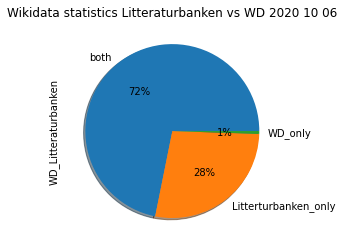

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [20]:
mergeCheckNumber

both                    1653
Litterturbanken_only     636
WD_only                   12
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [25]:
mergewithLibris

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,2019-10-16,2014-03-13,53hlsf1p1mc2mpw,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,2019-10-16,2017-04-14,ljx00mt45v0dfx5,both
3,Q365923,AchariusE,Q365923,AchariusE,True,2019-10-16,2018-02-01,dbqtx0hx5srsg85,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9,both
5,Q109244,AdamBremen,Q109244,AdamBremen,True,2019-10-16,2014-02-05,53hkk5vp1k798w1,both
...,...,...,...,...,...,...,...,...,...
1995,NaN,SimonsenM,Q1886707,SimonsenM,True,2019-12-09,2014-03-12,dbqsnnnx5flknct,Litterturbanken_only
1998,NaN,AnderssonE,NaN,AnderssonE,True,2019-10-16,2014-02-11,pm135h77182cbrc,Litterturbanken_only
2000,NaN,SandbergA,NaN,SandbergA,True,2019-10-16,2014-02-11,75kmq58r1twg518,Litterturbanken_only
2001,NaN,BrantingA,NaN,BrantingA,True,2019-10-16,2014-02-11,sq461wrb1pd33qx,Litterturbanken_only


In [24]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
plotmerge = mergewithLibris.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
plotmerge.plot( kind = 'bar',subplots=True) 
plt.title("LIBRIS ")
plt.savefig('LitteraturbankenWDLibris.png')
plt.show()


ValueError: pie requires either y column or 'subplots=True'

In [ ]:
mergewithLibris.info()

In [ ]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [ ]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


In [ ]:
LitteraturbankenTotShow.info()

In [ ]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

In [ ]:
df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [ ]:
df[df['authorid'].str.contains("BjörkmanE")] 

1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [ ]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


In [ ]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="both"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

In [ ]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [ ]:
dfmerge_authorid_norm.info()

In [ ]:
dfmerge_authorid_norm.head()

In [ ]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [ ]:
dfmerge["WD_Litteraturbanken"].value_counts()  

In [ ]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

In [ ]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

In [ ]:
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()]

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use 

In [ ]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [ ]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

In [ ]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy()  
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))


In [ ]:
dfmergeDeleteBoth.info()

In [ ]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))